         ID  \
0      8236   
1      8237   
2      8238   
3      8239   
4      8240   
...     ...   
2181  10417   
2182  10418   
2183  10419   
2184  10420   
2185  10421   

                                                                                                                                         EDU_NAME  \
0                                 Государственное бюджетное общеобразовательное учреждение города Москвы «Школа № 390 имени генерала П.И. Батова»   
1            Государственное казенное общеобразовательное учреждение города Москвы кадетская школа-интернат № 5 «Преображенский кадетский корпус»   
2     Государственное казенное общеобразовательное учреждение города Москвы «Специальная (коррекционная) общеобразовательная школа-интернат № 31»   
3                                                Частное учреждение общеобразовательная организация «Московская интернациональная школа «Планета»   
4                                                               Автономная

(221, b'smtp36.i.mail.ru closing connection')

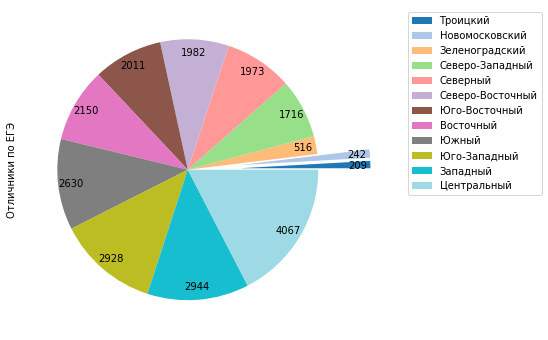

In [8]:
'''
Задание 16. Автоматические отчёты
Соберите отчёт по результатам ЕГЭ в 2018-2019 году, используя данные
https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv
и отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.

В отчёте должно быть:
• общее число отличников (учеников, получивших более 220 баллов по ЕГЭ в Москве),
• распределение отличников по округам Москвы,
• название школы с лучшими результатами по ЕГЭ в Москве.
Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).
Дополнительно: приложите к отчёту PDF документ того же содержания (дублирующий письмо).
Сколько учеников набрало 220 и больше баллов по ЕГЭ в Москве в 2018-2019 году?
'''

import pandas as pd # Импортирование библиотеки Pandas
import matplotlib.pyplot as plt # Импортирование библиотеки Matplotlib
import pdfkit # Импортирование библиотеки Pdfkit
from io import BytesIO # Импортирование библиотеки BytesIO
import binascii # Импортирование библиотеки Binascii
import smtplib # Импортирование библиотеки Smtplib
from email import encoders # Импортирование из модуля Email библиотеки encoders
from email.mime.text import MIMEText # Импортирование библиотеки MIMEText
from email.mime.base import MIMEBase # Импортирование библиотеки MIMEBase
from email.mime.multipart import MIMEMultipart # Импортирование библиотеки MIMEMultipart

data = pd.read_csv("https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv", delimiter=";") 
# Загрузка csv-файла и разделение столбцов по ";" в строках CSV-файла
print (data) # Вывод данных Pandas из переменной data
print ("----------------------------------------------------------------------------------------------------------------")
# Вывод разделяющей строки для лучшего восприятия данных
data = data[data["YEAR"] == "2018-2019"] # Выделение данных 2018-2019 годов 
data_best = data.sort_values("PASSES_OVER_220", ascending=False).head(1) 
# Нахождение лучшей школы по результатам ЕГЭ, взятие первого из сортированных значений по “Passes_Over_220”.
data["AdmArea"] = data["AdmArea"].apply(lambda x: x.split(" ")[0]) 
# Выполнение группировки по административному округу. 
# Удаление всех слов кроме первого для лучшего отображения с помощью лямбда функции
data_adm = data[["AdmArea", "PASSES_OVER_220"]].groupby("AdmArea").sum()["PASSES_OVER_220"].sort_values() 
# Группировка по административному округу. Сортировка, для того чтобы
# самые малочисленные округа на графике вынести из графика, чтобы подписи поместились на сектор соответствующий этим районам. 
total = data_adm.sum() # Подсчёт общего числа отличников

fig = plt.figure(figsize=(11,6)) # Создание холста и его размера
area = fig.add_subplot(1,1,1) # Создание подобласти
explode = [0]*len(data_adm) # Создание списка секторов
explode[0] = 0.4 # Мера выноса из основной диаграммы сектора
explode[1] = 0.4 # Мера выноса из основной диаграммы сектора
data_adm.plot.pie(ax = area, # Создание круговой диаграммы по округам
                 labels=[""]*len(data_adm), # передача пустого набора данных по числу округов
                 label="Отличники по ЕГЭ", # вывод названия диаграммы
                 cmap="tab20", # подбор цветов для диаграммы
                 autopct=lambda x:int(round(total * x/100)), # вывод автоподписи, сформированной из доли точного значения отличников 
                 pctdistance=0.9, # расстояние между центром каждой доли и началом текстовой метки, определяющиеся параметром autopct
                 explode=explode) # вынесенная из диаграммы на заданное расстояние часть долей 
plt.legend(data_adm.index, bbox_to_anchor=(1.5,1,0.1,0)) # Вывод легенды с подписями округов
img = BytesIO() # Создание объекта в памяти для отображения и сохранения изображения
plt.savefig(img) # Сохранение объекта в памяти
img = 'data:image/png;base64,' + binascii.b2a_base64(img.getvalue(), newline=False).decode("UTF-8") 
# Для вставки изображения в отчёт преобразование его в base64 кодировку
pd.set_option("display.max_colwidth", 1000) 
# Для корректного вывода длинного названия школы задаётся настойка Pandas по длине значения в колонке 

# Формирование html-отчёта со всеми данными:
'''
Создание кодировки, вставка суммарного значения числа отличников, 
распределение по округам и название лучшей школы.
'''
html = '''<html> 
<head>
    <title>Результаты ЕГЭ Москвы: отличники</title>
    <meta charset="utf-8"/>
</head>
<body>
    <h1>Результаты ЕГЭ Москвы: отличники в 2018-2019 году</h1>
    <p>Всего: ''' + str(total) + '''</p> # вставка суммарного значения числа отличников 
    <img src="''' + img + '''" alt="Отличники по округам"/>
    <p>Лучшая школа: ''' + str(data_best["EDU_NAME"].values[0]) + '''</p>
</body>
</html>'''
config = pdfkit.configuration(wkhtmltopdf="C:\\Program Files\\wkhtmltopdf\\bin\\wkhtmltopdf.exe") 
# Формирование PDF-отчёта через PDFkit. Конфигурация бинарного файла
options = {
    'page-size': 'A4', # размер страницы
    'header-right': '[page]' # вывод номера на каждой странице, его расположение
} 
pdfkit.from_string(html, 'C:\\Users\\Roman\\Downloads\\Ege.best.pdf', configuration=config, options=options) 
# Вызов генерации PDF-документа из строки, сохранение в файл 'Ege.best.pdf'

# Отправка письма с отчётами:
letter = MIMEMultipart() # Создание объекта MIMEMultipart
letter["From"] = "roma...@mail.ru" # Создание поля от кого
letter["Subject"] = "Результаты по ЕГЭ в Москве" # Создание поля "Тема письма"
letter["Content-Type"] = "text/html; charset=utf-8" # Создание поля тип передаваемой информации
letter["To"] = "mik...@mail.com" # Создание поля кому
letter.attach(MIMEText(html, "html")) # Прикрепление html-документа к письму
attachement = MIMEBase("application", "pdf") # Прикрепление pdf-документа к письму
attachement.set_payload(open("C:\\Users\\Roman\\Downloads\\Ege.best.pdf", "rb").read()) # чтение pdf-документа  
attachement.add_header("Content-Disposition", 'attachement; filename="C:\\Users\\Roman\\Downloads\\Ege.best.pdf"') 
# добавление заголовков
encoders.encode_base64(attachement) # перекодировка  
letter.attach(attachement) # прикрепление файла к письму 
user = "roma...@mail.ru" # логин пользователя от почтового ящика
password = "------" # пароль пользователя от почтового ящика (пароль приложений) 
server = smtplib.SMTP_SSL("smtp.mail.ru", 465) # отправка на порт сервера 465
# Подключение к почтовому серверу (Yandex, Google, Mail – в зависимости, где почтовый ящик)
server.login(user, password) # аутентификация
server.sendmail("roma...@mail.ru", "mik...@mail.ru", letter.as_string()) # адреса для сервера от кого кому отправлять   
server.quit() # Завершение сеанса сервера

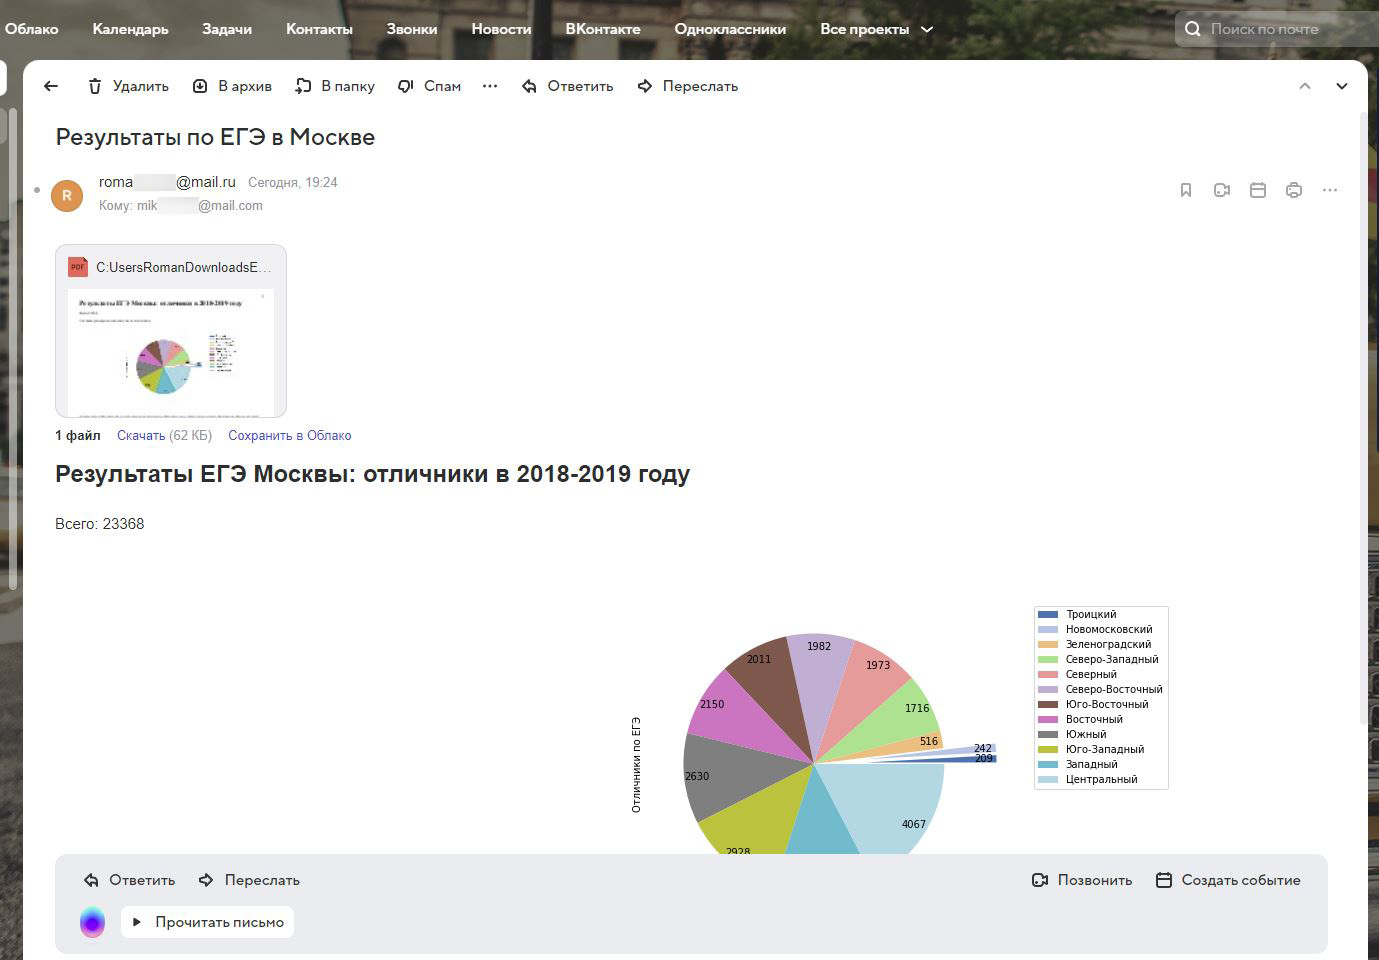

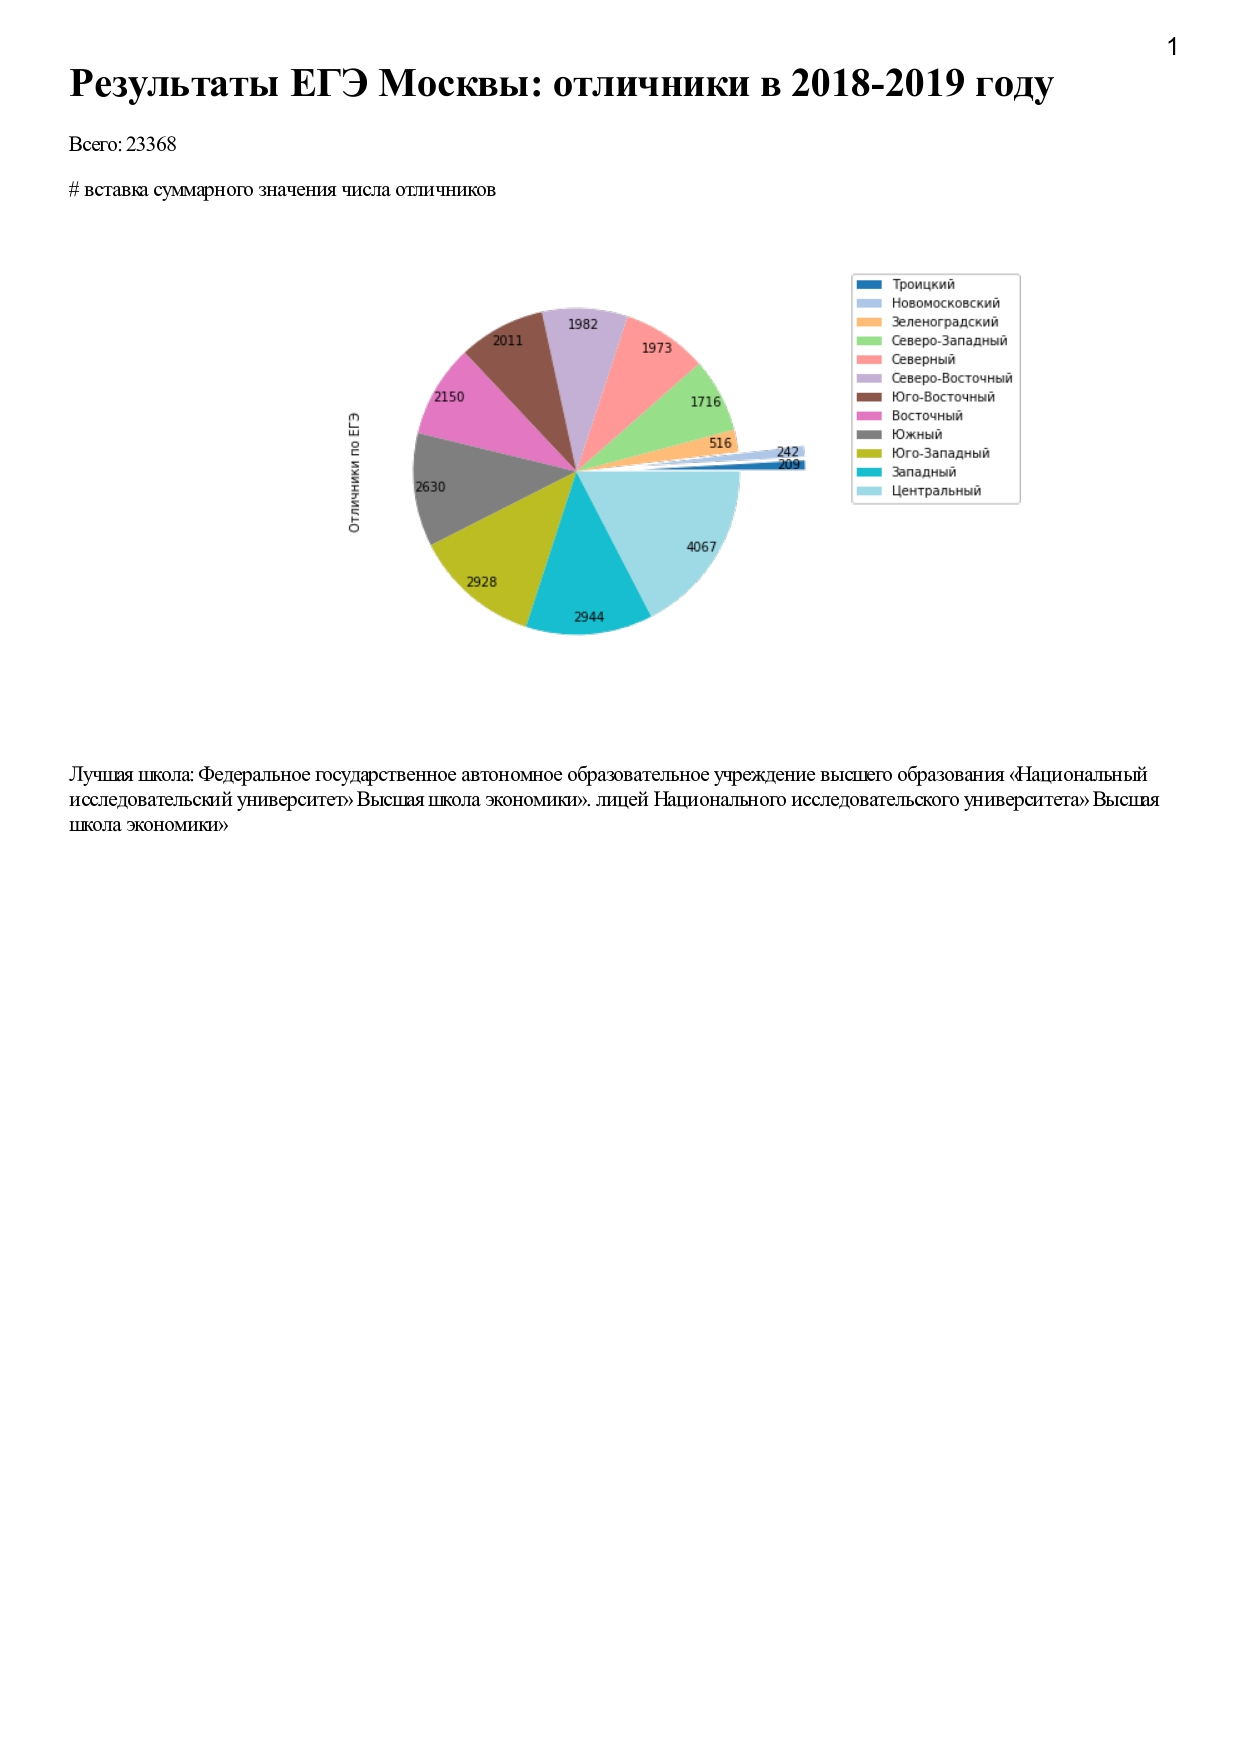